In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import os
import pickle
import json
import re
from PIL import Image

In [2]:
tf.test.is_gpu_available()

True

In [3]:
# create giant dictionary for all data
data_dir = '../facebook_challenge_data/'
model_dir = 'models/'

def get_dict(path):
    data_dict = OrderedDict()
    jsonl_content = open(path, 'r').read()
    data = [json.loads(jline) for jline in jsonl_content.split('\n')]
    for datum in data: data_dict[datum['id']] = datum
    return data_dict

train_dict = get_dict(data_dir + 'train.jsonl')
val_dict = get_dict(data_dir + 'dev.jsonl')
test_dict = get_dict(data_dir + 'test.jsonl')

print(len(train_dict))
print(len(val_dict))
print(len(test_dict))

8500
500
1000


In [4]:
from random import randint # for random cropping
from tensorflow.keras.preprocessing.sequence import pad_sequences

class FBMMDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_dict, tokenizer, pad_len, batch_size=32, dim=(299, 299), 
                 n_channels=3, shuffle=True, test=False):
        'Initialization'
        self.dim = dim
        self.data_dict = data_dict
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.pad_len = pad_len
        self.tokenizer = tokenizer
        
        # build labels list and id list
        self.id_list = list(self.data_dict.keys())
        self.img_list = {ID: self.data_dict[ID]['img'] for ID in self.id_list}
        if test: self.labels = {ID: 0 for ID in self.id_list}
        else: self.labels = {ID: self.data_dict[ID]['label'] for ID in self.id_list}
            
        # get text dictionary
        self.text_dict = self.process_text(self.id_list)
        
        self.on_epoch_end()
        self.classes = [self.labels[self.id_list[i]] for i in self.indexes]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X_txt, X_img, y = self.__data_generation(id_list_temp)
        
        return (X_txt, X_img), y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_img = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        X_txt = np.empty((len(id_list_temp), self.pad_len))
        y = np.empty(len(id_list_temp), dtype=int)

        # Generate data
        for i, ID in enumerate(id_list_temp):
            # Store sample
            X_img[i,] = self.process_img(data_dir + self.img_list[ID])
            X_txt[i,] = self.text_dict[ID]

            # Store class
            y[i] = self.labels[ID]

        return X_txt.astype(int), X_img, y
    
    def process_img(self, path): # method for getting image
        img = Image.open(path)
        img.load()
        scale_size = int(1.5 * self.dim[0]) # want cropping
        if img.size[0] < img.size[1]: # width greater than height
            wpercent = (scale_size/float(img.size[0]))
            hsize = int((float(img.size[1])*float(wpercent)))
            img = img.resize((scale_size,hsize), Image.ANTIALIAS)
        else: # height greater than width
            hpercent = (scale_size/float(img.size[1]))
            wsize = int((float(img.size[0])*float(hpercent)))
            img = img.resize((wsize, scale_size), Image.ANTIALIAS)
            
        data = np.asarray(img, dtype='uint8')
        im = self.augment(data) # apply transformation
        
        
        if im.shape==(self.dim[0], self.dim[1]): im = np.stack((im,)*3, axis=-1) # handle grayscale
        if im.shape == (*self.dim, 4): im = im[:,:,:3] # handle weird case
        
        return im
    
    def augment(self, im): # random crop and random mirror
        
        # random crop
        x_max, y_max = im.shape[0], im.shape[1]
        x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
        im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
        # random mirror
        if randint(0,1): im = np.flip(im, axis=1)
        
        return im
    
    def process_text(self, id_list):
        
        # matrix for texts
        texts = [self.data_dict[ID]['text'] for ID in id_list]
        sequences = [self.tokenizer.encode(text) for text in texts] # make this more efficient...
        text_seqs = pad_sequences(sequences, maxlen=self.pad_len)
        
        id_to_seq = {ID: txt for (ID, txt) in zip(id_list, text_seqs)} # map id to text seq
        
        return id_to_seq

In [25]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, TFRobertaModel
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_len = 100

batch_size = 12

# create data generators
train_gen = FBMMDataGenerator(data_dict=train_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

val_gen = FBMMDataGenerator(data_dict=val_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

# Define model

In [26]:
import transformers
from tensorflow.keras import layers

class BERT(transformers.TFBertModel):
    def __init__(self, config, *inputs, **kwargs):
        super(BERT, self).__init__(config, *inputs, **kwargs)
        self.bert.call = tf.function(self.bert.call)


class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.resnet = tf.keras.applications.ResNet152V2(include_top=False, 
                                                             weights='imagenet', 
                                                             input_shape=(224, 224, 3))
        self.bert = BERT.from_pretrained('bert-base-uncased')
        
        self.text_embedding = self.bert.get_input_embeddings().word_embeddings
         
        self.pooling = layers.AveragePooling2D(pool_size=(2, 2), padding='same')
        self.reshape = layers.Reshape((4 * 4, 2048)) # 3 is from 7//2
        self.W_ns = [layers.Dense(self.bert.config.hidden_size) for _ in range(self.reshape.target_shape[0])]
        
        self.concat = layers.Concatenate(axis=1)
        
        self.dropout = layers.Dropout(0.1)
        self.denseout = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        text, image = inputs
        
        # handle image
        image = tf.keras.applications.resnet_v2.preprocess_input(image)
        image_emb = self.resnet(image)
        image_emb = self.pooling(image_emb)
        image_emb = self.reshape(image_emb)
        image_embeds = [self.W_ns[i](image_emb[:, i]) for i in range(self.reshape.target_shape[0])]
        image_emb = tf.keras.backend.stack(image_embeds, axis=1)
        # print(image_emb.shape) # does give (16, 9, 768) as desired
        
        # handle text
        text_emb = tf.gather(self.text_embedding, text)
        
        # concat and feed to bert
        concat_emb = self.concat([text_emb, image_emb])
        seg_ids = np.concatenate((np.zeros(max_len, dtype=np.int64), 
                                  np.ones(self.reshape.target_shape[0], dtype=np.int64)))
        bert_encodings = self.bert(inputs={'inputs_embeds': concat_emb,
                                                'token_type_ids': seg_ids})[0]
        doc_encoding = tf.squeeze(bert_encodings[:, 0:1, :], axis=1)
        doc_encoding = self.dropout(doc_encoding)
        
        output = self.denseout(doc_encoding)
        
        return output

model = MyModel()

In [35]:
# custom loss for AUC
# https://towardsdatascience.com/explicit-auc-maximization-70beef6db14e

# http://tflearn.org/objectives/#roc-auc-score
# https://github.com/tflearn/tflearn/blob/master/tflearn/objectives.py
# https://github.com/keras-team/keras/issues/1732

def rankboost_loss(y_true, y_pred):
    with tf.name_scope("RocAucScore"):

        pos = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))

        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 1)

        # original paper suggests performance is robust to exact parameter choice
        gamma = 0.2
        p     = 3

        difference = tf.zeros_like(pos * neg) + pos - neg - gamma

        masked = tf.boolean_mask(difference, difference < 0.0)

        return tf.reduce_sum(tf.pow(-masked, p))
#     y = y_true
#     activations = tf.math.log(1. / y_pred - 1.) # perform inverse sigmoid
#     ones = np.ones(batch_size)
#     return - tf.reduce_mean(tf.sigmoid(activations @ tf.transpose(activations)) * 
#                         np.maximum(y @ ones.T - ones @ y.T, 0))

optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss=rankboost_loss, metrics=['accuracy', tf.keras.metrics.AUC()])

In [36]:
# train model
from tensorflow.keras.callbacks import ModelCheckpoint

weight_file = 'custom_loss_bert_bt_weights_fb.h5'

mcp_save = ModelCheckpoint(model_dir + weight_file, 
                           save_weights_only=True, 
                           save_best_only=True, 
                           verbose=1,
                           monitor='val_auc', 
                           mode='max')

history = model.fit_generator(train_gen,
                    validation_data=val_gen,
                    shuffle=True,
                    epochs=5,
                    callbacks=[mcp_save])

Epoch 1/5
Instructions for updating:
Use tf.identity instead.
709/709 [==============================] - 1394s 2s/step - loss: 0.2499 - accuracy: 0.6381 - auc_24: 0.5182 - val_loss: 0.2593 - val_accuracy: 0.5000 - val_auc_24: 0.5208
Epoch 2/5
709/709 [==============================] - 1367s 2s/step - loss: 0.2002 - accuracy: 0.6412 - auc_24: 0.6750 - val_loss: 0.2471 - val_accuracy: 0.5000 - val_auc_24: 0.6284
Epoch 3/5
709/709 [==============================] - 1364s 2s/step - loss: 0.1676 - accuracy: 0.6412 - auc_24: 0.7447 - val_loss: 0.2415 - val_accuracy: 0.5000 - val_auc_24: 0.6349
Epoch 4/5
709/709 [==============================] - 1369s 2s/step - loss: 0.1503 - accuracy: 0.6412 - auc_24: 0.7923 - val_loss: 0.2764 - val_accuracy: 0.5000 - val_auc_24: 0.6358
Epoch 5/5
709/709 [==============================] - 1367s 2s/step - loss: 0.1234 - accuracy: 0.6412 - auc_24: 0.8348 - val_loss: 0.2568 - val_accuracy: 0.5000 - val_auc_24: 0.6519


In [37]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
bert_1 (BERT)                multiple                  109482240 
_________________________________________________________________
average_pooling2d_1 (Average multiple                  0         
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
dense_17 (Dense)             multiple                  1573632   
_________________________________________________________________
dense_18 (Dense)             multiple                  1573632   
_________________________________________________________________
dense_19 (Dense)             multiple                  1

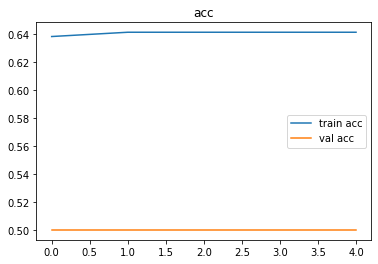

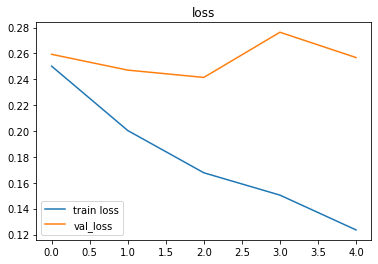

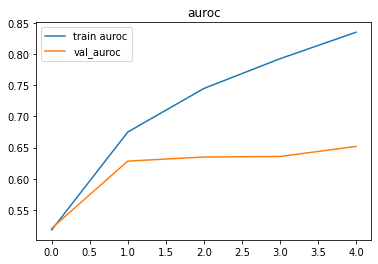

In [39]:
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.title('acc')
plt.show()

plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(history.history['auc_24'], label = 'train auroc')
plt.plot(history.history['val_auc_24'], label = 'val_auroc')
plt.legend()
plt.title('auroc')
plt.show()

In [ ]:
model.load_weights(model_dir + weight_file)

In [40]:
val_gen = FBMMDataGenerator(data_dict=val_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=12,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

In [ ]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import math

y_val = val_gen.classes

# get AUROC
preds = model.predict_generator(val_gen)
print('Val AUROC:', roc_auc_score(y_val, preds))

# get optimal threhold
mx, thresh = 0, 0
preds_bin = np.array(preds)

for t in np.linspace(0, 1, 101):
    preds_bin[preds >= t] = 1
    preds_bin[preds < t] = 0
    acc = accuracy_score(y_val, preds_bin)
    if acc > mx: mx, thresh = acc, t
        
# print(thresh)

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds>thresh] = 1
preds_bin[preds<=thresh] = 0
print('Val Accuracy:', accuracy_score(y_val, preds_bin))

# get F1
print('Test F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_val, preds_bin, zero_division=1))

In [ ]:
test_gen = FBMMDataGenerator(data_dict=test_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=12,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=False,
                          test=True)

ids = test_gen.id_list

preds = model.predict_generator(test_gen)
preds = np.squeeze(preds)

preds_bin = np.array(preds)
preds_bin[preds >= thresh] = 1
preds_bin[preds < thresh] = 0

# write to csv
import csv

with open('custom_loss_mmbt_submission.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(["id", "proba", "label"])
    for ID, prob, lab in zip(ids, preds, preds_bin):
        wr.writerow([ID, prob, int(lab)])